<a href="https://colab.research.google.com/github/stiwari-ds/data-science-competitions/blob/main/analytics_vidhya/ml_summer_training_2022/notebooks/01_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

SEED = 23
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [2]:
train_url = 'https://raw.githubusercontent.com/stiwari-ds/data-science-competitions/main/analytics_vidhya/ml_summer_training_2022/data/raw/train.csv'
test_url = 'https://raw.githubusercontent.com/stiwari-ds/data-science-competitions/main/analytics_vidhya/ml_summer_training_2022/data/raw/test.csv'

In [3]:
train = pd.read_csv(train_url)
test = pd.read_csv(test_url)

# Data overview

In [4]:
train.head()

,loan_id,age,education,proof_submitted,loan_amount,asset_cost,no_of_loans,no_of_curr_loans,last_delinq_none,loan_default
0,1,27,1.0,Aadhar,504264,820920,2,2,0,0
1,2,48,1.0,Aadhar,728556,831444,6,2,0,0
2,3,30,2.0,VoterID,642936,826092,0,0,0,1
3,4,28,1.0,Aadhar,746556,930924,0,0,0,0
4,5,29,1.0,Aadhar,1139880,1902000,0,0,0,0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   loan_id           7000 non-null   int64  
 1   age               7000 non-null   int64  
 2   education         6755 non-null   float64
 3   proof_submitted   7000 non-null   object 
 4   loan_amount       7000 non-null   int64  
 5   asset_cost        7000 non-null   int64  
 6   no_of_loans       7000 non-null   int64  
 7   no_of_curr_loans  7000 non-null   int64  
 8   last_delinq_none  7000 non-null   int64  
 9   loan_default      7000 non-null   int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 547.0+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   loan_id           3000 non-null   int64  
 1   age               3000 non-null   int64  
 2   education         2908 non-null   float64
 3   proof_submitted   3000 non-null   object 
 4   loan_amount       3000 non-null   int64  
 5   asset_cost        3000 non-null   int64  
 6   no_of_loans       3000 non-null   int64  
 7   no_of_curr_loans  3000 non-null   int64  
 8   last_delinq_none  3000 non-null   int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 211.1+ KB


# TARGET: loan_default

In [7]:
TARGET = 'loan_default'

In [8]:
train[TARGET].value_counts()

0    4200
1    2800
Name: loan_default, dtype: int64

In [9]:
train[TARGET].value_counts(normalize=True)

0    0.6
1    0.4
Name: loan_default, dtype: float64

# Feature distributions

### loan_id

In [10]:
train.loan_id.nunique(), test.loan_id.nunique()

(7000, 3000)

In [11]:
set(train.loan_id.unique()).intersection(set(test.loan_id.unique()))

set()

Confirmed as a unique identifier. We can drop it as a feature.

### age

In [12]:
def plot_num(feature):
    fig, ax = plt.subplots(1, 2, figsize=(20, 4))
    plt.suptitle(f'Feature: {feature}', fontweight='bold', fontsize=12)
    sns.kdeplot(x=feature, data=train, ax=ax[0])
    ax[0].set_title(f'Density distribution in train dataset')
    sns.kdeplot(x=feature, data=train, hue=TARGET, ax=ax[1])
    ax[1].set_title(f'Split distribution based on target class')
    fig.tight_layout()
    plt.show()

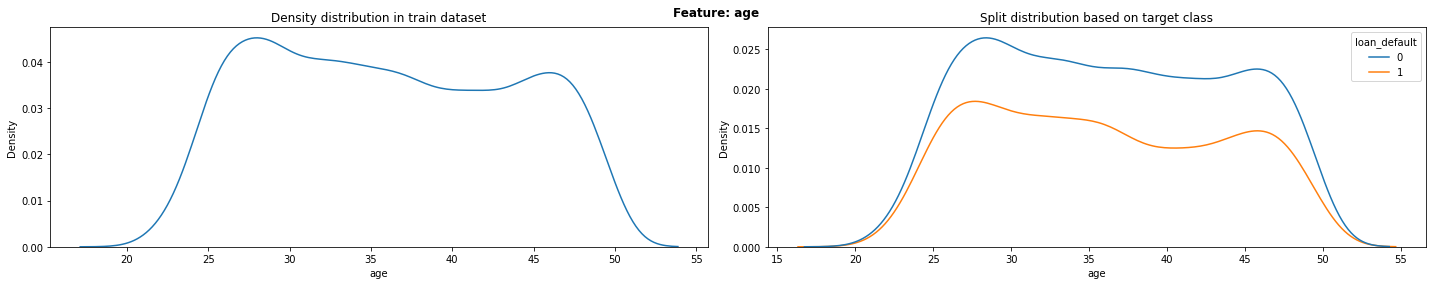

In [13]:
plot_num('age')

Visually similar distributions for both target classes. The only difference is a slight dip in positive class for age range around 37 to 45.

### education

In [14]:
train.education.value_counts(dropna=False)

2.0    3796
1.0    2959
NaN     245
Name: education, dtype: int64

In [15]:
def plot_cat(feature):
    fig, ax = plt.subplots(1, 2, figsize=(20, 4))
    plt.suptitle(f'Feature: {feature}', fontweight='bold', fontsize=12)
    sns.countplot(x=feature, data=train, ax=ax[0])
    ax[0].set_title('Count distribution in train dataset')
    sns.countplot(x=feature, data=train, hue=TARGET, ax=ax[1])
    ax[1].set_title('Split distribution based on target class')
    fig.tight_layout()
    plt.show()

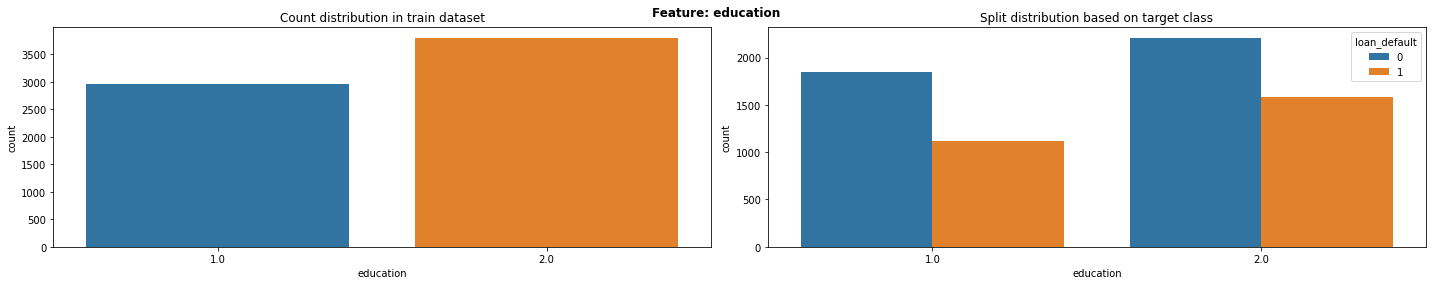

In [16]:
plot_cat('education')

In [17]:
train.groupby('education')[TARGET].value_counts(normalize=True)

education  loan_default
1.0        0               0.6228
           1               0.3772
2.0        0               0.5817
           1               0.4183
Name: loan_default, dtype: float64

Approximately the same split distribution, so we cannot expect a lot of information from this feature. We can fill in the missing values in any way and it may not impact the information much.

In [18]:
train.loc[train.education.isna()][TARGET].value_counts(normalize=True)

0    0.6082
1    0.3918
Name: loan_default, dtype: float64

Split distribution for missing values is also bisecting that for the two categories. 

### proof_submitted

In [19]:
train['proof_submitted'].unique(), test['proof_submitted'].unique()

(array(['Aadhar', 'VoterID', 'Driving', 'PAN', 'Passport'], dtype=object),
 array(['Aadhar', 'VoterID', 'Driving', 'PAN', 'Passport'], dtype=object))

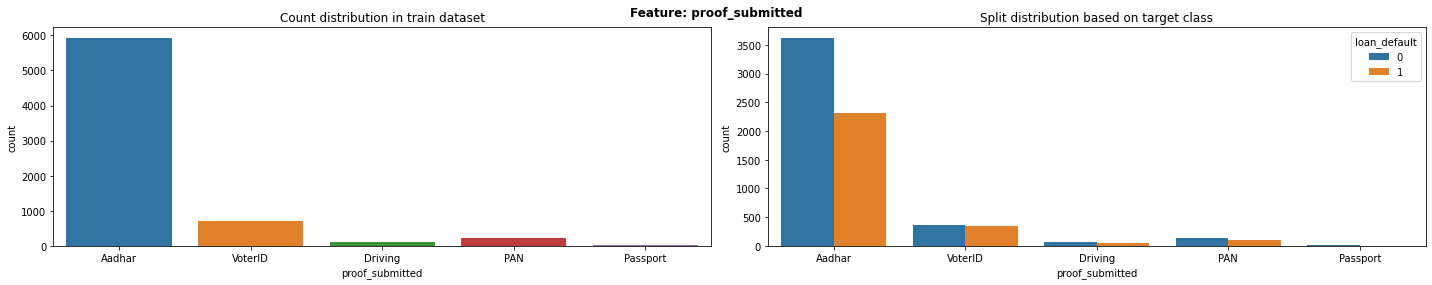

In [20]:
plot_cat('proof_submitted')

In [21]:
train.proof_submitted.value_counts()

Aadhar      5931
VoterID      707
PAN          235
Driving      114
Passport      13
Name: proof_submitted, dtype: int64

Heavily imbalanced feature. Again, difficult to gain information about the target variable.

In [22]:
train.groupby('proof_submitted')[TARGET].value_counts(normalize=True)

proof_submitted  loan_default
Aadhar           0               0.6109
                 1               0.3891
Driving          0               0.5351
                 1               0.4649
PAN              0               0.5872
                 1               0.4128
Passport         0               0.7692
                 1               0.2308
VoterID          0               0.5205
                 1               0.4795
Name: loan_default, dtype: float64

In [23]:
train.loc[train.proof_submitted != 'Aadhar'][TARGET].value_counts(normalize=True)

0    0.5398
1    0.4602
Name: loan_default, dtype: float64

We can create a boolean feature based on whether proof submitted was 'Aadhar' or not, to reduce imbalance while having some difference in the split distribution.

### loan_amount

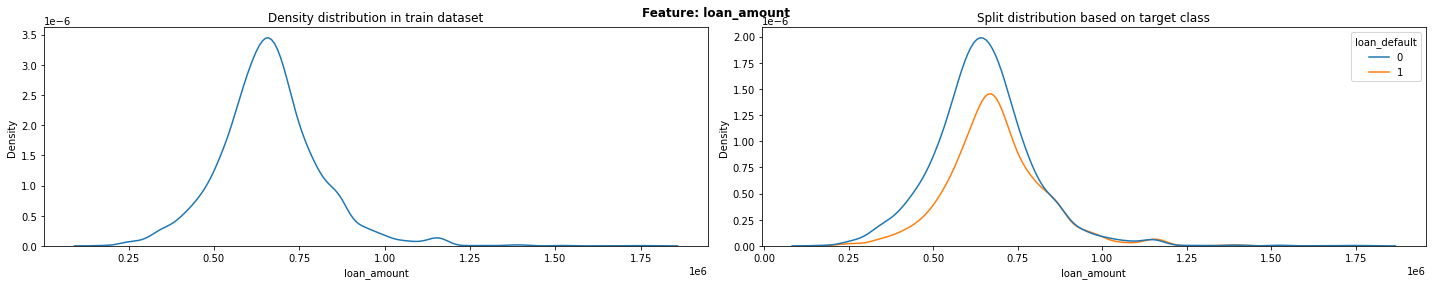

In [24]:
plot_num('loan_amount')

Expected a separation in peaks with higher loan amounts having higher proportion of defaults, but the splits have a very slight shift.

### asset_cost

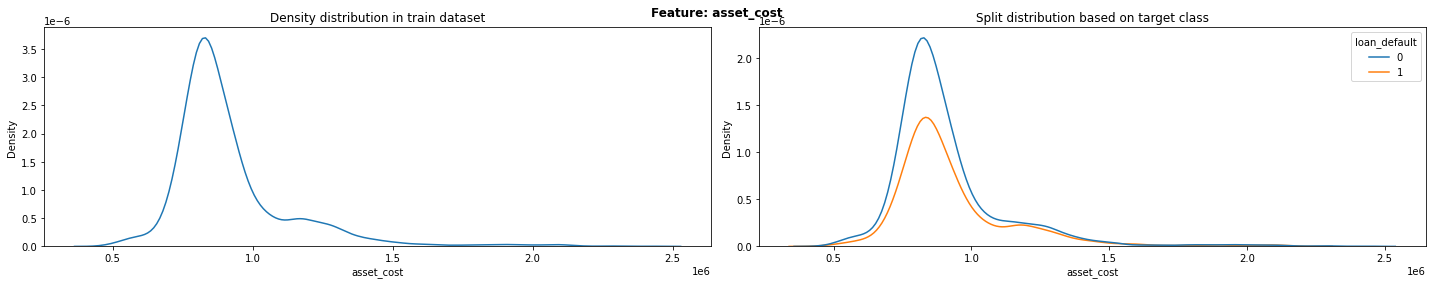

In [25]:
plot_num('asset_cost')

Again, a similar density distribution for both classes. 

### no_of_loans

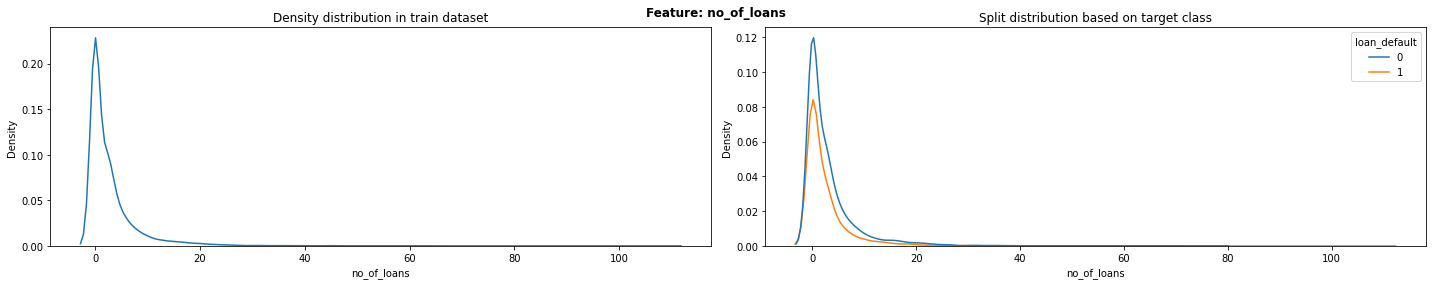

In [26]:
plot_num('no_of_loans')

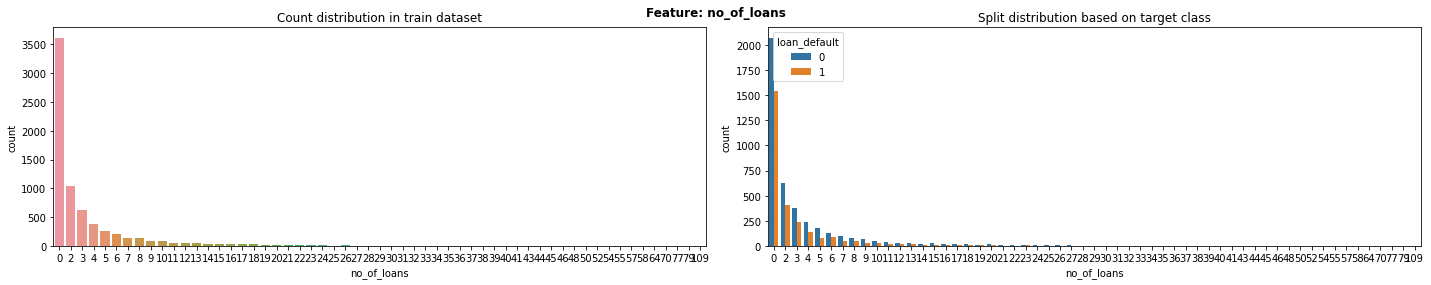

In [27]:
plot_cat('no_of_loans')

In [28]:
len(train.loc[train.no_of_loans > 10])

445

In [29]:
train.loc[train.no_of_loans > 10][TARGET].value_counts()

0    295
1    150
Name: loan_default, dtype: int64

In [30]:
train.loc[train.no_of_loans > 25][TARGET].value_counts()

0    36
1    21
Name: loan_default, dtype: int64

In [31]:
train.loc[train.no_of_loans > 50][TARGET].value_counts()

0    6
1    5
Name: loan_default, dtype: int64

A surprisingly normal proportion of defaulters for such a high number of loans.  
But these include past loans which may have been repaid. A person who regularly repays loans would be more reliable for future loans too.

We also have to consider that such high number of loans in the dataset can be incorrect entries which makes them outliers to be removed.

### no_of_curr_loans

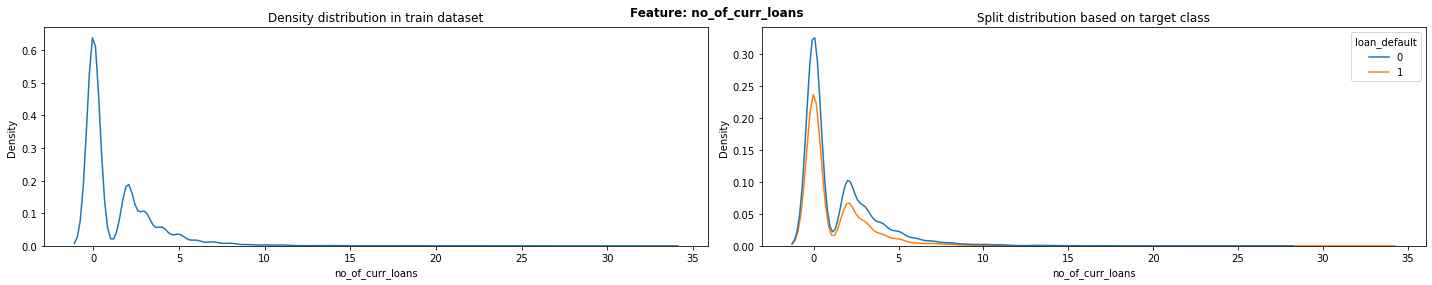

In [32]:
plot_num('no_of_curr_loans')

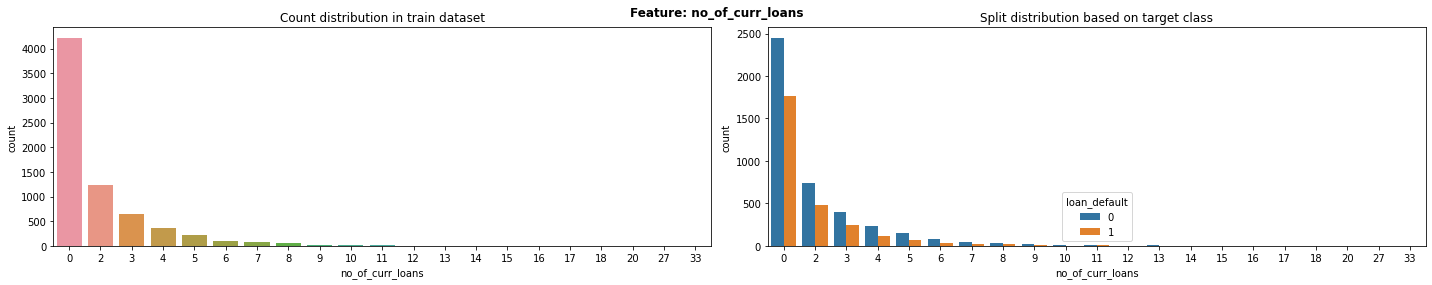

In [33]:
plot_cat('no_of_curr_loans')

In [34]:
train.loc[train.no_of_curr_loans < 6][TARGET].value_counts(normalize=True)

0    0.5955
1    0.4045
Name: loan_default, dtype: float64

In [35]:
train.loc[train.no_of_curr_loans > 8][TARGET].value_counts(normalize=True)

0    0.6989
1    0.3011
Name: loan_default, dtype: float64

Finally we see a strong indicator that matches our common sense. People holding higher number of active loans are more likely to default. 

### last_delinq_none

In [36]:
train.last_delinq_none.value_counts(normalize=True)

0    0.9867
1    0.0133
Name: last_delinq_none, dtype: float64

Extremely imbalanced.

In [37]:
train.groupby('last_delinq_none')[TARGET].value_counts(normalize=True)

last_delinq_none  loan_default
0                 0               0.6008
                  1               0.3992
1                 0               0.5376
                  1               0.4624
Name: loan_default, dtype: float64

We see a difference in proportion of defaulters which is informative but the extreme imbalance in this feature can reduce the effect on target variable.

# Handling missing values

In [38]:
train.isna().sum()

loan_id               0
age                   0
education           245
proof_submitted       0
loan_amount           0
asset_cost            0
no_of_loans           0
no_of_curr_loans      0
last_delinq_none      0
loan_default          0
dtype: int64

In [39]:
test.isna().sum()

loan_id              0
age                  0
education           92
proof_submitted      0
loan_amount          0
asset_cost           0
no_of_loans          0
no_of_curr_loans     0
last_delinq_none     0
dtype: int64

After exploring the 'education' column we saw that filling in either value will not change the distribution much. So, we can try different strategies and create a column for each of them, later picking only one of them based on feature selection insights.

In [40]:
train.education.unique()

array([ 1.,  2., nan])

In [41]:
train['education_fill_1'] = train['education'].fillna(1).astype('int')
test['education_fill_1'] = test['education'].fillna(1).astype('int')

train['education_fill_2'] = train['education'].fillna(2).astype('int')
test['education_fill_2'] = test['education'].fillna(2).astype('int')

# Feature engineering

### Binning continuous features 
(tree-based models can find the splits but we can also manually create them if we want to use linear models or neural networks)  
* age -> age_range
* loan_amount -> loan_amount_range
* asset_cost -> asset_cost_range
* no_of_loans -> no_of_loans_range
* no_of_curr_loans -> no_of_curr_loans_range

**age**

In [42]:
train.age.min(), train.age.max(), test.age.min(), test.age.max()

(21, 50, 21, 50)

In [43]:
age_bins = [20, 27, 35, 44, 50]
train['age_range'] = pd.cut(x=train.age, bins=age_bins, labels=False, ordered=True)
test['age_range'] = pd.cut(x=test.age, bins=age_bins, labels=False, ordered=True)

**loan_amount**

In [44]:
train.loan_amount.min(), train.loan_amount.max(), test.loan_amount.min(), test.loan_amount.max()

(167880, 1781376, 169680, 1576920)

In [45]:
loan_bins = [0, 0.5e6, 0.8e6, 2e6]
train['loan_amount_range'] = pd.cut(x=train.loan_amount, bins=loan_bins, labels=False, ordered=True)
test['loan_amount_range'] = pd.cut(x=test.loan_amount, bins=loan_bins, labels=False, ordered=True)

**asset_cost**

In [46]:
train.asset_cost.min(), train.asset_cost.max(), test.asset_cost.min(), test.asset_cost.max()

(473352, 2419200, 470604, 2358180)

In [47]:
asset_bins = [0, 0.75e6, 1e6, 1.25e6, 2.5e6]
train['asset_cost_range'] = pd.cut(x=train.asset_cost, bins=asset_bins, labels=False, ordered=True)
test['asset_cost_range'] = pd.cut(x=test.asset_cost, bins=asset_bins, labels=False, ordered=True)

**no_of_loans**

In [48]:
train.no_of_loans.min(), train.no_of_loans.max(), test.no_of_loans.min(), test.no_of_loans.max()

(0, 109, 0, 92)

In [49]:
num_loans_bins = [-1, 1, 2, 10, 20, 110] #starting with -1 to include 0 in 1st bin
train['no_of_loans_range'] = pd.cut(x=train.no_of_loans, bins=num_loans_bins, labels=False, ordered=True)
test['no_of_loans_range'] = pd.cut(x=test.no_of_loans, bins=num_loans_bins, labels=False, ordered=True)

**no_of_curr_loans**

In [50]:
train.no_of_curr_loans.min(), train.no_of_curr_loans.max(), test.no_of_curr_loans.min(), test.no_of_curr_loans.max()

(0, 33, 0, 32)

In [51]:
num_curr_loans_bins = [-1, 1, 2, 6, 10, 35] #starting with -1 to include 0 in 1st bin
train['no_of_curr_loans_range'] = pd.cut(x=train.no_of_curr_loans, bins=num_curr_loans_bins, labels=False, ordered=True)
test['no_of_curr_loans_range'] = pd.cut(x=test.no_of_curr_loans, bins=num_curr_loans_bins, labels=False, ordered=True)

### Reclassifying categorical columns
converting 'proof_submitted' column from multi-class to binary (Aadhar vs Non-Aadhar)

In [52]:
train['proof_is_aadhar'] = (train['proof_submitted'] == 'Aadhar').astype('int')
test['proof_is_aadhar'] = (test['proof_submitted'] == 'Aadhar').astype('int')

**Encoding the original 'proof_submitted' column**

In [53]:
proof_mapping = dict(zip(train.proof_submitted.unique(), range(5)))

train['proof_submitted'].replace(to_replace=proof_mapping, inplace=True)
test['proof_submitted'].replace(to_replace=proof_mapping, inplace=True)

# Feature selection

In [54]:
features = [f for f in test.columns if f not in ('loan_id', 'education')]

num_features = ['age', 'loan_amount', 'asset_cost', 'no_of_loans', 'no_of_curr_loans']
cat_features = [f for f in features if f not in num_features]

### Feature correlation

In [55]:
corr_df = train[features].corr()

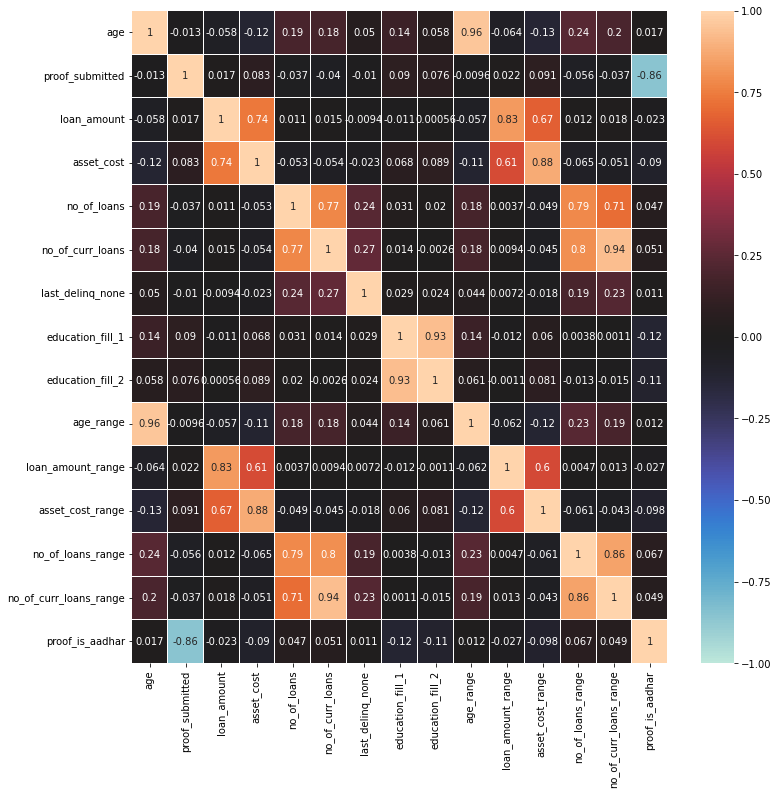

In [56]:
plt.figure(figsize=(12, 12))
sns.heatmap(corr_df, vmin=-1, vmax=1, center=0, annot=True, linewidths=0.1)
plt.show()

Except the high correlation within derived features, there is:
* moderately-high correlation between loan_amount and asset_cost (probably because a loan is given after assessing the assets)  
* moderately-high correlation between no_of_loans and no_of_current_loans  

Apart from the derived features, there are no features with high enough correlation to consider their removal.

### Correlation with target

In [57]:
train[features + [TARGET]].corr()[TARGET]

age                      -0.0296
proof_submitted           0.0313
loan_amount               0.1157
asset_cost                0.0480
no_of_loans              -0.0457
no_of_curr_loans         -0.0573
last_delinq_none          0.0148
education_fill_1          0.0407
education_fill_2          0.0399
age_range                -0.0313
loan_amount_range         0.1091
asset_cost_range          0.0447
no_of_loans_range        -0.0628
no_of_curr_loans_range   -0.0574
proof_is_aadhar          -0.0522
loan_default              1.0000
Name: loan_default, dtype: float64

Very low correlation between features and target.  
However, the target is categorical so we need to perform other statistical tests to understand which features are useful.

### Chi-square test of independence (categorical feature - categorical target)

In [58]:
chi2_test = chi2(train[cat_features], train[TARGET])

pd.DataFrame(
    data={
        'chi2-statistic': chi2_test[0], 
        'p-value': chi2_test[1],
        'accepted?': chi2_test[1] < 0.05
    },
    index=cat_features
)

,chi2-statistic,p-value,accepted?
proof_submitted,12.4838,4.1049e-04,True
last_delinq_none,1.5072,2.1957e-01,False
education_fill_1,1.8696,1.7152e-01,False
education_fill_2,1.7245,1.8911e-01,False
age_range,4.2392,3.9501e-02,True
loan_amount_range,20.6240,5.5891e-06,True
asset_cost_range,6.1672,1.3014e-02,True
no_of_loans_range,34.1342,5.1439e-09,True
no_of_curr_loans_range,29.2699,6.2966e-08,True
proof_is_aadhar,2.9136,8.7835e-02,False


### ANOVA F-test (continuous feature - categorical target)

In [59]:
anova_test = f_classif(train[num_features], train[TARGET])

pd.DataFrame(
    data={
        'f-statistic': anova_test[0], 
        'p-value': anova_test[1],
        'accepted?': anova_test[1] < 0.05
    },
    index=num_features
)

,f-statistic,p-value,accepted?
age,6.1248,1.3353e-02,True
loan_amount,95.0098,2.6253e-22,True
asset_cost,16.1739,5.8392e-05,True
no_of_loans,14.6701,1.2918e-04,True
no_of_curr_loans,23.0567,1.6057e-06,True


### Mutual Information score

In [60]:
cat_mask = [(f in cat_features) for f in features] #boolean mask for discrete features

mi_scores = mutual_info_classif(train[features], train[TARGET], 
                                discrete_features=cat_mask, 
                                random_state=SEED)

mi_score_percent = mi_scores / sum(mi_scores) * 100

pd.DataFrame(
    data={'mi_score': mi_scores,
          'mi_score_percent': mi_score_percent}, 
    index=features
)

,mi_score,mi_score_percent
age,0.0128,23.0452
proof_submitted,0.0018,3.2292
loan_amount,0.0131,23.6948
asset_cost,0.0075,13.5115
no_of_loans,0.0034,6.1236
no_of_curr_loans,0.0021,3.7804
last_delinq_none,0.0001,0.1944
education_fill_1,0.0008,1.5015
education_fill_2,0.0008,1.4419
age_range,0.0007,1.2084


### Variance Inflation Factor (to detect redundant continuous features)

In [61]:
%%capture
!pip install --upgrade statsmodels==0.13.2
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [66]:
def remove_vif_features(X: pd.DataFrame, threshold: float = 5.0) -> list:
    """Remove feature with highest Variance Inflation Factor
    at every iteration until all remaining features are below
    a certain threshold.
    """
    i = 0
    while True:
        vif = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
        max_vif = np.max(vif)

        if max_vif <= threshold:
            break

        i += 1
        col_to_remove = X.columns[np.argmax(vif)]
        print(f"Iteration {i}: {col_to_remove:20} ({max_vif:.4f})")
        X.drop(col_to_remove, axis=1, inplace=True)

    if i == 0:
        print(f"No columns removed")
    else:
        print(pd.DataFrame({"Feature": X.columns, "VIF": vif}))

    return list(X.columns)

**checking redundant features at different thresholds** (most redundant feature removed at each iteration)  
* rule-of-thumb threshold = 5

In [67]:
_ = remove_vif_features(train[num_features].copy(), 10) #lenient threshold

Iteration 1: loan_amount          (42.7282)
Iteration 2: age                  (10.4717)
            Feature     VIF
0        asset_cost  1.3473
1       no_of_loans  3.1794
2  no_of_curr_loans  3.4497


In [68]:
_ = remove_vif_features(train[num_features].copy(), 5)

Iteration 1: loan_amount          (42.7282)
Iteration 2: age                  (10.4717)
            Feature     VIF
0        asset_cost  1.3473
1       no_of_loans  3.1794
2  no_of_curr_loans  3.4497


In [69]:
_ = remove_vif_features(train[num_features].copy(), 2.5) #strictest threshold

Iteration 1: loan_amount          (42.7282)
Iteration 2: age                  (10.4717)
Iteration 3: no_of_curr_loans     (3.4497)
       Feature     VIF
0   asset_cost  1.2395
1  no_of_loans  1.2395


# Final feature sets and processed datasets

In [72]:
train.head()

,loan_id,age,education,proof_submitted,loan_amount,asset_cost,no_of_loans,no_of_curr_loans,last_delinq_none,loan_default,education_fill_1,education_fill_2,age_range,loan_amount_range,asset_cost_range,no_of_loans_range,no_of_curr_loans_range,proof_is_aadhar
0,1,27,1.0,0,504264,820920,2,2,0,0,1,1,0,1,1,1,1,1
1,2,48,1.0,0,728556,831444,6,2,0,0,1,1,3,1,1,2,1,1
2,3,30,2.0,1,642936,826092,0,0,0,1,2,2,1,1,1,0,0,0
3,4,28,1.0,0,746556,930924,0,0,0,0,1,1,1,1,1,0,0,1
4,5,29,1.0,0,1139880,1902000,0,0,0,0,1,1,1,2,3,0,0,1


In [71]:
features

['age', 'proof_submitted', 'loan_amount', 'asset_cost', 'no_of_loans', 'no_of_curr_loans', 'last_delinq_none', 'education_fill_1', 'education_fill_2', 'age_range', 'loan_amount_range', 'asset_cost_range', 'no_of_loans_range', 'no_of_curr_loans_range', 'proof_is_aadhar']

In [80]:
original_features = ['age', 'education_fill_1', 'proof_submitted', 
                     'loan_amount', 'asset_cost', 'no_of_loans', 
                     'no_of_curr_loans', 'last_delinq_none']

selected_features = ['age', 'proof_submitted', 'loan_amount', 
                     'asset_cost', 'no_of_loans', 'no_of_curr_loans']

In [74]:
train[cat_features] = train[cat_features].astype('category')
test[cat_features] = test[cat_features].astype('category')

In [78]:
train[features].to_csv('train_all_features.csv', index=False)
test[features].to_csv('test_all_features.csv', index=False)

In [81]:
train[original_features].to_csv('train_original_filled.csv', index=False)
test[original_features].to_csv('test_original_filled.csv', index=False)

In [82]:
train[selected_features].to_csv('train_selected_features.csv', index=False)
test[selected_features].to_csv('test_selected_features.csv', index=False)